In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.callbacks import CSVLogger
import pandas as pd

from tensorflow.keras.initializers import Initializer
from sklearn.cluster import KMeans
from keras import backend as K
from keras.initializers import RandomUniform, Initializer, Constant
from sklearn.svm import SVC

C:\Users\acer\.conda\envs\dataMining\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\acer\.conda\envs\dataMining\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\acer\.conda\envs\dataMining\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\acer\.conda\envs\dataMining\lib\site-packages\tensorflow\pyth

## (a) Nonlinearly separable data (double moon with negative d)

define function to create moon data with each moon contains `n_samples` points.  The dataset has 2*`n_samples` points.  

In [2]:
def make_moon_dataset(n_samples=1000, r=10, w=6, d=0):

    pi = math.pi
    rad = r-w/2 # radious of inner circle

    c1 = np.array([0,0])
    c2 =  np.array([10,-d])

    # We use random radius in the interval [rad, rad+thk]
    #  and random angles from 0 to pi radians.
    r1 = np.random.rand(n_samples)*w+rad
    a1 = np.random.rand(n_samples)*np.pi

    r2 = np.random.rand(n_samples)*w+rad
    a2 = np.random.rand(n_samples)*np.pi+np.pi

    # In order to plot it we convert it to cartesian:
    p1 = np.array((r1*np.cos(a1), r1*np.sin(a1)))
    p2 = np.array((r2*np.cos(a2), r2*np.sin(a2)))

    x1, y1 = (p1[0] + c1[0], p1[1] + c1[1])
    x2, y2 = (p2[0] + c2[0], p2[1] + c2[1])
    
    return x1, y1, x2, y2

### MLP

d = -4

Generate dataset consists of 2000 points for each half moon.

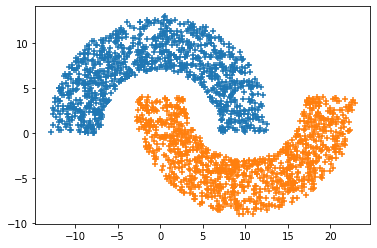

In [3]:
n_samples=1000
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-4)

plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

In [4]:
ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

Mentioned in the reference book, the shape of our MLP is 2$\times$20$\times$1.  The learning rate should decrease linearly from 1e-1 to 1e-5.  However, the optimizer is not specified in the book, and I have tried `learning rate scheduler` and apply `SGD` but did not get a good result.  Eventually, I decide to use the `Adam` optimizer.  

In [5]:
model = Sequential()
model.add(Dense(units=20, input_dim=2, activation='tanh'))
model.add(Dense(units=1, input_dim=20, activation='tanh'))

model.compile(optimizer='adam',
              loss='MSE',
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
csv_logger = CSVLogger('logs/double_moon_mlp_-4.csv')

history = model.fit(X, y, 
                    callbacks=[csv_logger],
                    epochs=50)

Epoch 1/50
2000/2000 [==============================] - 0s 59us/sample - loss: 1.1827 - acc: 0.2810
Epoch 2/50
2000/2000 [==============================] - 0s 28us/sample - loss: 0.2892 - acc: 0.3910
Epoch 3/50
2000/2000 [==============================] - 0s 34us/sample - loss: 0.2290 - acc: 0.4260
Epoch 4/50
2000/2000 [==============================] - 0s 22us/sample - loss: 0.2049 - acc: 0.4280
Epoch 5/50
2000/2000 [==============================] - 0s 29us/sample - loss: 0.1880 - acc: 0.4305
Epoch 6/50
2000/2000 [==============================] - 0s 29us/sample - loss: 0.1744 - acc: 0.4345
Epoch 7/50
2000/2000 [==============================] - 0s 28us/sample - loss: 0.1633 - acc: 0.4350
Epoch 8/50
2000/2000 [==============================] - 0s 27us/sample - loss: 0.1542 - acc: 0.4375
Epoch 9/50
2000/2000 [==============================] - 0s 28us/sample - loss: 0.1467 - acc: 0.4375
Epoch 10/50
2000/2000 [==============================] - 0s 27us/sample - loss: 0.1398 - acc: 0.4400

In [7]:
y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

Accuracy: 0.9975


The loss decreases fast in the first 5 epochs, and slowly decrease afterwards.  

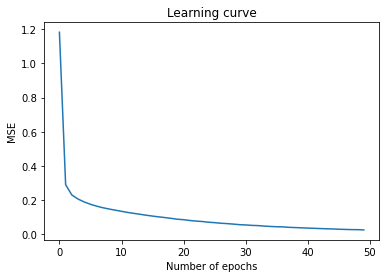

In [8]:
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/double_moon_mlp_-4.csv")
training_loss = pd.DataFrame({'MSE':training_log.loss}, index=training_log.epoch)
training_loss.plot.line(title='Learning curve', legend=False)
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

In [9]:
def plot_decision_boundaries(X,y,model):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1

    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.2)
    x2grid = np.arange(min2, max2, 0.2)

    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    Z_ = []
    for z_ in Z:
        z_ = np.array([1 if z > 0 else -1 for z in z_])
        Z_.append(z_)
    Z_ = np.vstack(Z_)
    
    plt.scatter(X[:,0], X[:,1], c=y, marker='+', linewidths=0.1)
    plt.contourf(xx, yy, Z_, cmap=plt.cm.Paired, alpha=0.2)
    plt.show()

Test on dataset of total 2000 points and plot the decision boundary.  

Accuracy: 0.998


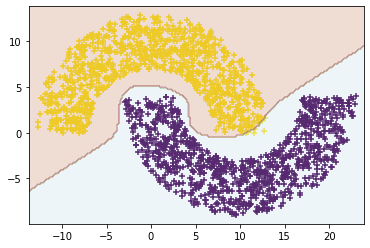

In [10]:
n_samples=1000
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-4)
ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]
y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))
plot_decision_boundaries(X, y, model)

Repeat for d = -5

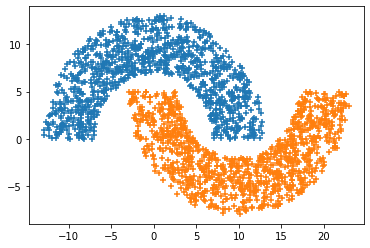

In [11]:
n_samples=1000
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-5)

plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

In [12]:
ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

In [13]:
model = Sequential()
model.add(Dense(units=20, input_dim=2, activation='tanh'))
model.add(Dense(units=1, input_dim=20, activation='tanh'))

model.compile(optimizer='adam',
              loss='MSE',
              metrics=['accuracy'])

In [14]:
csv_logger = CSVLogger('logs/double_moon_mlp_-5.csv')

history = model.fit(X, y, 
                    callbacks=[csv_logger],
                    epochs=50)

Epoch 1/50
2000/2000 [==============================] - 0s 49us/sample - loss: 0.5119 - acc: 0.2020
Epoch 2/50
2000/2000 [==============================] - 0s 26us/sample - loss: 0.3399 - acc: 0.3675
Epoch 3/50
2000/2000 [==============================] - 0s 27us/sample - loss: 0.3012 - acc: 0.4380
Epoch 4/50
2000/2000 [==============================] - 0s 23us/sample - loss: 0.2715 - acc: 0.4365
Epoch 5/50
2000/2000 [==============================] - 0s 24us/sample - loss: 0.2529 - acc: 0.4345
Epoch 6/50
2000/2000 [==============================] - 0s 25us/sample - loss: 0.2369 - acc: 0.4335
Epoch 7/50
2000/2000 [==============================] - 0s 25us/sample - loss: 0.2256 - acc: 0.4325
Epoch 8/50
2000/2000 [==============================] - 0s 25us/sample - loss: 0.2154 - acc: 0.4320
Epoch 9/50
2000/2000 [==============================] - 0s 26us/sample - loss: 0.2059 - acc: 0.4310
Epoch 10/50
2000/2000 [==============================] - 0s 27us/sample - loss: 0.1978 - acc: 0.4330

Accuracy: 0.997


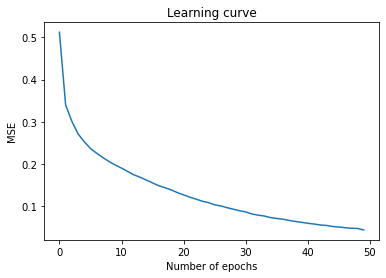

In [15]:
y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

training_log = pd.DataFrame()
training_log = pd.read_csv("logs/double_moon_mlp_-5.csv")
training_loss = pd.DataFrame({'MSE':training_log.loss}, index=training_log.epoch)
training_loss.plot.line(title='Learning curve', legend=False)
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

Accuracy: 0.995


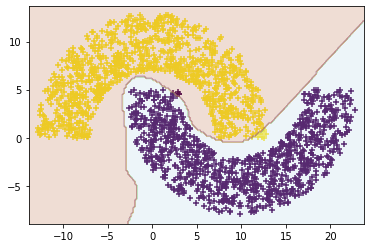

In [16]:
n_samples=1000
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-5)
ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)
X = ds[:,:2]
y = ds[:,2]
y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))
plot_decision_boundaries(X, y, model)

### RBF

d = -5

Create dataset of 1000 points.

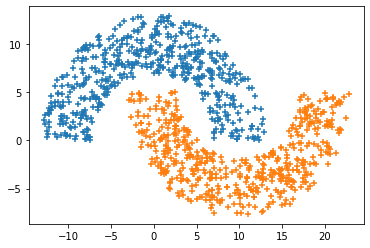

In [17]:
n_samples=500
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-5)

plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

In [18]:
ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

Create RBF layer.  The input dim is 2 and output dim being 20.  The number of clusters in kmeans is 20.  

In [19]:
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, n_centers=20, max_iter=300):
        self.X = X
        self.n_centers=n_centers
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        #assert shape[1] == self.X.shape[1]

        #n_centers = shape[0]
        km = KMeans(n_clusters=self.n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_
    
class RBFLayer(tf.keras.layers.Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))


    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Here we replace some terms in gaussian distribution to `betas`

betas = $\frac{1}{2\sigma^2}$

In [20]:
model = Sequential()
model.add(RBFLayer(20,
                   initializer=InitCentersKMeans(X, n_centers=20),
                   betas=1/(2*2.6**2),
                   input_shape=(2,)))
model.add(tf.keras.layers.Activation(tf.keras.activations.tanh))
model.add(Dense(units=1, input_dim=20, activation='tanh'))

model.compile(optimizer='adam',
              loss='MSE',
              metrics=['accuracy'])

In [21]:
csv_logger = CSVLogger('logs/double_moon_rbf_-5.csv')

history = model.fit(X, y, 
                    callbacks=[csv_logger],
                    epochs=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
1000/1000 [==============================] - 0s 98us/sample - loss: 0.9434 - acc: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 0s 32us/sample - loss: 0.7137 - acc: 0.0600
Epoch 3/50
1000/1000 [==============================] - 0s 30us/sample - loss: 0.5385 - acc: 0.1760
Epoch 4/50
1000/1000 [==============================] - 0s 36us/sample - loss: 0.4912 - acc: 0.1840
Epoch 5/50
1000/1000 [==============================] - 0s 27us/sample - loss: 0.4469 - acc: 0.2200
Epoch 6/50
1000/1000 [==============================] - 0s 26us/sample - loss: 0.4180 - acc: 0.2630
Epoch 7/50
1000/1000 [==============================] - 0s 27us/sample - loss: 0.3938 - acc: 0.2730
Epoch 8/50
1000/1000 [==============================] - 0s 29us/sample - loss: 0.3594 - acc: 0.3080
Epoch 9/50
1000/1000 [==============================] - 0s 26us/sample - loss: 0.3378 - acc: 0.3330
Ep

The loss is not like that in the reference book.  I think it may be the difference of optimizer and learning rate.  After all, the result seems to be acceptable.  

Accuracy: 0.99


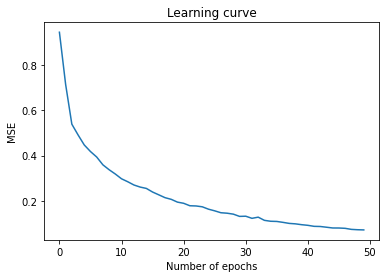

In [22]:
y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

training_log = pd.DataFrame()
training_log = pd.read_csv("logs/double_moon_rbf_-5.csv")
training_loss = pd.DataFrame({'MSE':training_log.loss}, index=training_log.epoch)
training_loss.plot.line(title='Learning curve', legend=False)
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

Test on dataset of 2000 points.

Accuracy: 0.9965


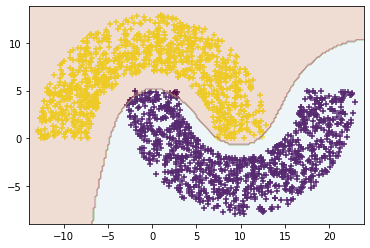

In [23]:
n_samples=1000
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-5)
ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]
y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))
plot_decision_boundaries(X, y, model)

Repeat for d = -6

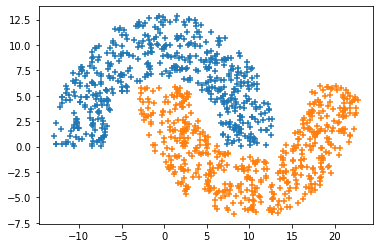

In [24]:
n_samples=500
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-6)

plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

In [25]:
model = Sequential()
model.add(RBFLayer(20,
                   initializer=InitCentersKMeans(X, n_centers=20),
                   betas=1/(2*2.4**2),
                   input_shape=(2,)))
model.add(tf.keras.layers.Activation(tf.keras.activations.tanh))
model.add(Dense(units=1, input_dim=20, activation='tanh'))

model.compile(optimizer='adam',
              loss='MSE',
              metrics=['accuracy'])

In [26]:
csv_logger = CSVLogger('logs/double_moon_rbf_-6.csv')

history = model.fit(X, y, 
                    callbacks=[csv_logger],
                    epochs=50)

Epoch 1/50
1000/1000 [==============================] - 0s 99us/sample - loss: 1.1323 - acc: 0.0000e+00
Epoch 2/50
1000/1000 [==============================] - 0s 28us/sample - loss: 0.9705 - acc: 0.0000e+00
Epoch 3/50
1000/1000 [==============================] - 0s 30us/sample - loss: 0.8143 - acc: 0.0000e+00
Epoch 4/50
1000/1000 [==============================] - 0s 29us/sample - loss: 0.7263 - acc: 0.0000e+00
Epoch 5/50
1000/1000 [==============================] - 0s 28us/sample - loss: 0.6629 - acc: 0.0000e+00
Epoch 6/50
1000/1000 [==============================] - 0s 31us/sample - loss: 0.6145 - acc: 0.0000e+00
Epoch 7/50
1000/1000 [==============================] - 0s 28us/sample - loss: 0.5729 - acc: 0.0040
Epoch 8/50
1000/1000 [==============================] - 0s 29us/sample - loss: 0.5365 - acc: 0.0460
Epoch 9/50
1000/1000 [==============================] - 0s 28us/sample - loss: 0.5037 - acc: 0.0900
Epoch 10/50
1000/1000 [==============================] - 0s 31us/sample - lo

Accuracy: 0.994


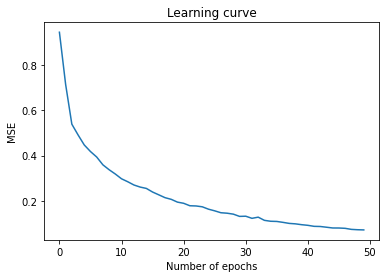

In [27]:
y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

training_log = pd.DataFrame()
training_log = pd.read_csv("logs/double_moon_rbf_-5.csv")
training_loss = pd.DataFrame({'MSE':training_log.loss}, index=training_log.epoch)
training_loss.plot.line(title='Learning curve', legend=False)
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

Accuracy: 0.9955


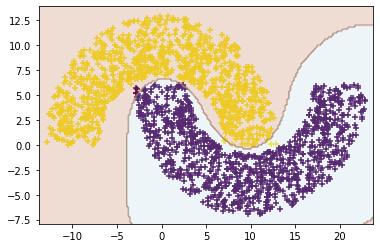

In [28]:
n_samples=1000
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-6)
ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))
plot_decision_boundaries(X, y, model)

### SVM

d = -6

Create dataset of 300 points. 

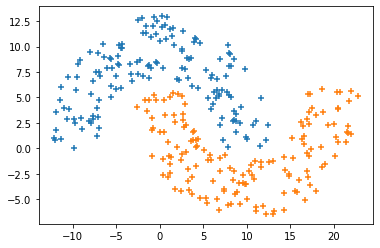

In [29]:
n_samples = 150
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-6)

plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

The `C` value in the book is set to infinity, so here I use a large value `1e+8`.

In [30]:
model = SVC(C=1e+8)
model.fit(X,y)

y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

Accuracy: 1.0


Test on dataset of 2000 points.

Accuracy: 0.9995


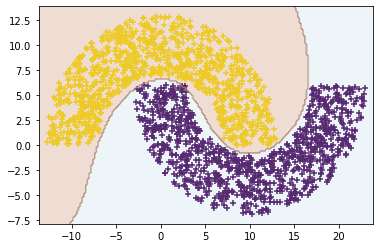

In [31]:
n_samples=1000
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-6)
ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))
plot_decision_boundaries(X, y, model)

Plot support vector

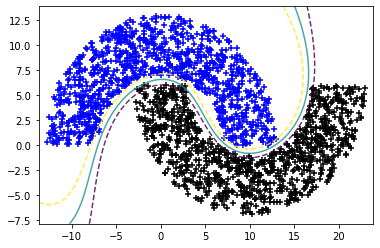

In [32]:
sv = model.support_vectors_
# define bounds of the domain
min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.2)
x2grid = np.arange(min2, max2, 0.2)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

color = ['blue' if y_==1 else 'black' for y_ in y]
plt.scatter(X[:,0], X[:,1], c=color, marker='+', linewidths=0.1)
plt.contour(xx, yy, Z, levels=[-1,0,1], alpha=0.8, linestyles=['--', '-', '--'])
plt.scatter(sv[:,0], sv[:,1], s=10, lw=1, facecolors='none')
plt.show()

Repeat for d=-6.5

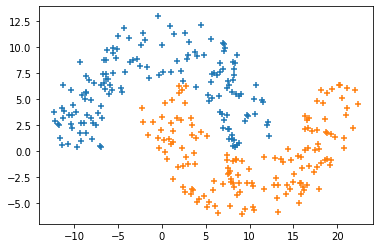

In [33]:
n_samples = 150
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-6.5)

plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

In [34]:
model = SVC(C=1e+8)
model.fit(X,y)

y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

Accuracy: 1.0


Test on dataset of 2000 points.

Accuracy: 0.9905


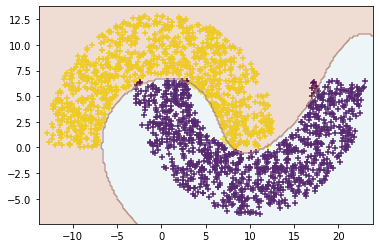

In [35]:
n_samples=1000
x1, y1, x2, y2 = make_moon_dataset(n_samples=n_samples, d=-6.5)
ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,-np.ones(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0 else -1 for y_ in y_pred])
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))
plot_decision_boundaries(X, y, model)

Plot support vector

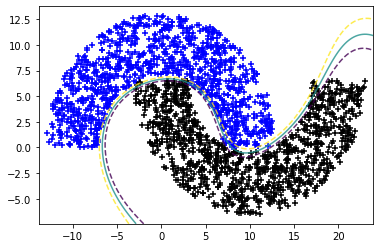

In [36]:
sv = model.support_vectors_
# define bounds of the domain
min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.2)
x2grid = np.arange(min2, max2, 0.2)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

color = ['blue' if y_==1 else 'black' for y_ in y]
plt.scatter(X[:,0], X[:,1], c=color, marker='+', linewidths=0.1)
plt.contour(xx, yy, Z, levels=[-1,0,1], alpha=0.8, linestyles=['--', '-', '--'])
plt.scatter(sv[:,0], sv[:,1], s=10, lw=1, facecolors='none')
plt.show()

## (b)	The non-separable 2-D Gaussian data

### MLP

In [37]:
def make_gaussian(mu1, mu2, sigma1, sigma2, n_samples=1000):
    x1 = np.random.normal(mu1[0], sigma1, n_samples)
    y1 = np.random.normal(mu1[1], sigma1, n_samples)
    x2 = np.random.normal(mu2[0], sigma2, n_samples)
    y2 = np.random.normal(mu2[1], sigma2, n_samples)
    
    return x1, y1, x2, y2

Training size = 500 

Numer of epoch = 320

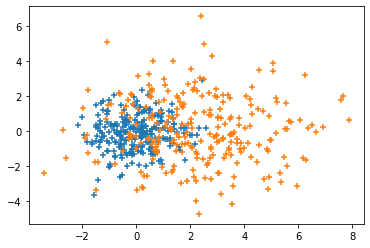

In [38]:
n_samples = 250
x1, y1, x2, y2 = make_gaussian([0,0], [2,0], 1, 2, n_samples)
plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,np.zeros(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

In [39]:
model = Sequential()
model.add(Dense(units=2, input_dim=2, activation='tanh'))
model.add(Dense(units=1, input_dim=2, activation='tanh'))
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5)
model.compile(optimizer=sgd,
              loss='MSE',
              metrics=['accuracy'])

In [40]:
csv_logger = CSVLogger('logs/gaussian_mlp_500.csv')

history = model.fit(X, y, 
                    callbacks=[csv_logger],
                    epochs=320,
                    verbose=0)

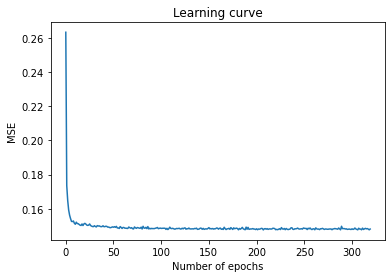

In [41]:
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/gaussian_mlp_500.csv")
training_loss = pd.DataFrame({'MSE':training_log.loss}, index=training_log.epoch)
training_loss.plot.line(title='Learning curve', legend=False)
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

In [42]:
y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0.5 else 0 for y_ in y_pred])
print('MSE: {}'.format(training_log.loss.values[-1]))
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

MSE: 0.14815333676338194
Accuracy: 0.796


---------------------------------------------------------------------------------------------------------------------------

Training size = 2000

Numer of epoch = 80

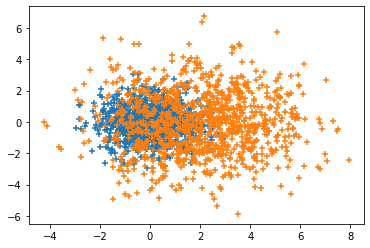

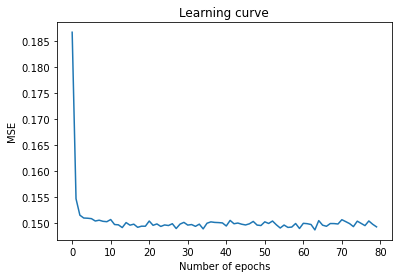

MSE: 0.149348171710968
Accuracy: 0.785


In [43]:
n_samples = 1000
x1, y1, x2, y2 = make_gaussian([0,0], [2,0], 1, 2, n_samples)
plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,np.zeros(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

model = Sequential()
model.add(Dense(units=2, input_dim=2, activation='tanh'))
model.add(Dense(units=1, input_dim=2, activation='tanh'))
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5)
model.compile(optimizer=sgd,
              loss='MSE',
              metrics=['accuracy'])

csv_logger = CSVLogger('logs/gaussian_mlp_2000.csv')

history = model.fit(X, y, 
                    callbacks=[csv_logger],
                    epochs=80,
                    verbose=0)

training_log = pd.DataFrame()
training_log = pd.read_csv("logs/gaussian_mlp_2000.csv")
training_loss = pd.DataFrame({'MSE':training_log.loss}, index=training_log.epoch)
training_loss.plot.line(title='Learning curve', legend=False)
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0.5 else 0 for y_ in y_pred])
print('MSE: {}'.format(training_log.loss.values[-1]))
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

---------------------------------------------------------------------------------------------------------------------------

Training size = 8000

Numer of epoch = 20

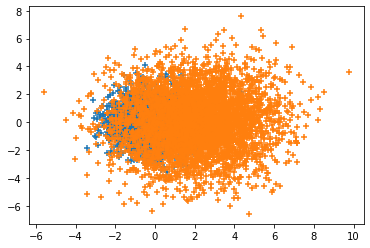

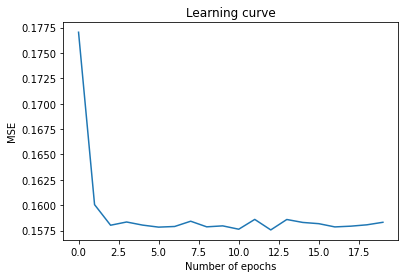

MSE: 0.15832026636600496
Accuracy: 0.774875


In [49]:
n_samples = 4000
x1, y1, x2, y2 = make_gaussian([0,0], [2,0], 1, 2, n_samples)
plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,np.zeros(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

model = Sequential()
model.add(Dense(units=2, input_dim=2, activation='relu'))
model.add(Dense(units=1, input_dim=2, activation='relu'))
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5)
model.compile(optimizer=sgd,
              loss='MSE',
              metrics=['accuracy'])

csv_logger = CSVLogger('logs/gaussian_mlp_8000.csv')

history = model.fit(X, y, 
                    callbacks=[csv_logger],
                    epochs=20,
                    verbose=0)

training_log = pd.DataFrame()
training_log = pd.read_csv("logs/gaussian_mlp_8000.csv")
training_loss = pd.DataFrame({'MSE':training_log.loss}, index=training_log.epoch)
training_loss.plot.line(title='Learning curve', legend=False)
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0.5 else 0 for y_ in y_pred])
print('MSE: {}'.format(training_log.loss.values[-1]))
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

---------------------------------------------------------------------------------------------------------------------------

### RBF

Here I use the RBFLayer designed in part (a) and use m = 100 clusters

n_samples = 250

number of epochs = 320

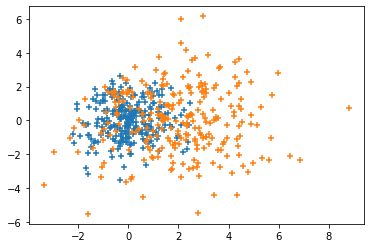

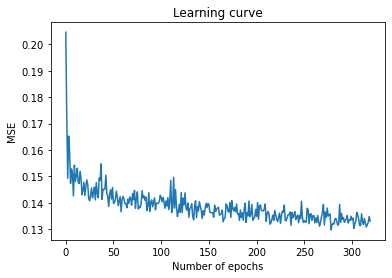

MSE: 0.13307128691673278
Accuracy: 0.808


In [45]:
n_samples = 250
x1, y1, x2, y2 = make_gaussian([0,0], [2,0], 1, 2, n_samples)
plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,np.zeros(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

model = Sequential()
model.add(RBFLayer(100,
                   initializer=InitCentersKMeans(X, n_centers=100),
                   betas=0.5,
                   input_shape=(2,)))
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(Dense(units=1, input_dim=2, activation='relu'))
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5)
model.compile(optimizer=sgd,
              loss='MSE',
              metrics=['accuracy'])

csv_logger = CSVLogger('logs/gaussian_rbf_500.csv')

history = model.fit(X, y, 
                    callbacks=[csv_logger],
                    epochs=320,
                    verbose=0)

training_log = pd.DataFrame()
training_log = pd.read_csv("logs/gaussian_rbf_500.csv")
training_loss = pd.DataFrame({'MSE':training_log.loss}, index=training_log.epoch)
training_loss.plot.line(title='Learning curve', legend=False)
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0.5 else 0 for y_ in y_pred])
print('MSE: {}'.format(training_log.loss.values[-1]))
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

---------------------------------------------------------------------------------------------------------------------------

n_samples = 2000

number of epochs = 80

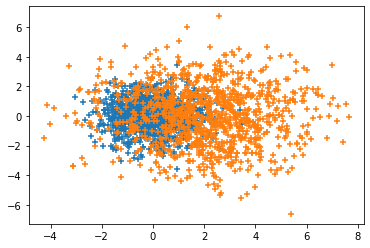

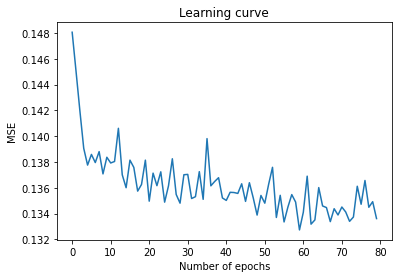

MSE: 0.1336116744875908
Accuracy: 0.8115


In [46]:
n_samples = 1000
x1, y1, x2, y2 = make_gaussian([0,0], [2,0], 1, 2, n_samples)
plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,np.zeros(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

model = Sequential()
model.add(RBFLayer(100,
                   initializer=InitCentersKMeans(X, n_centers=100),
                   betas=0.5,
                   input_shape=(2,)))
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(Dense(units=1, input_dim=2, activation='relu'))
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5)
model.compile(optimizer=sgd,
              loss='MSE',
              metrics=['accuracy'])

csv_logger = CSVLogger('logs/gaussian_rbf_2000.csv')

history = model.fit(X, y, 
                    callbacks=[csv_logger],
                    epochs=80,
                    verbose=0)

training_log = pd.DataFrame()
training_log = pd.read_csv("logs/gaussian_rbf_2000.csv")
training_loss = pd.DataFrame({'MSE':training_log.loss}, index=training_log.epoch)
training_loss.plot.line(title='Learning curve', legend=False)
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0.5 else 0 for y_ in y_pred])
print('MSE: {}'.format(training_log.loss.values[-1]))
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

---------------------------------------------------------------------------------------------------------------------------

n_samples = 8000

number of epochs = 20

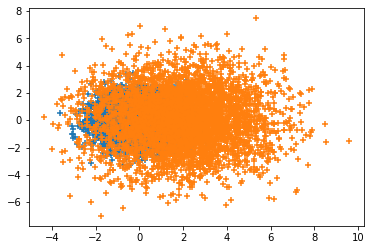

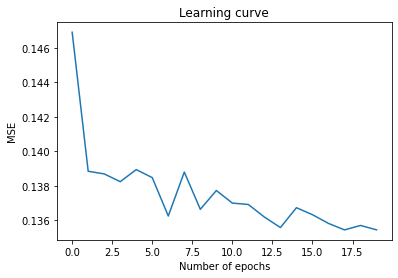

MSE: 0.13545007169246673
Accuracy: 0.816375


In [47]:
n_samples = 4000
x1, y1, x2, y2 = make_gaussian([0,0], [2,0], 1, 2, n_samples)
plt.scatter(x1, y1, marker='+', linewidths=0.1)
plt.scatter(x2, y2, marker='+', linewidths=0.1)
plt.show()

ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
ds1 = np.vstack((x2,y2,np.zeros(n_samples))).T
ds = np.vstack((ds0,ds1))
np.random.shuffle(ds)

X = ds[:,:2]
y = ds[:,2]

model = Sequential()
model.add(RBFLayer(100,
                   initializer=InitCentersKMeans(X, n_centers=100),
                   betas=0.5,
                   input_shape=(2,)))
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(Dense(units=1, input_dim=2, activation='relu'))
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5)
model.compile(optimizer=sgd,
              loss='MSE',
              metrics=['accuracy'])

csv_logger = CSVLogger('logs/gaussian_rbf_8000.csv')

history = model.fit(X, y, 
                    callbacks=[csv_logger],
                    epochs=20,
                    verbose=0)

training_log = pd.DataFrame()
training_log = pd.read_csv("logs/gaussian_rbf_8000.csv")
training_loss = pd.DataFrame({'MSE':training_log.loss}, index=training_log.epoch)
training_loss.plot.line(title='Learning curve', legend=False)
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.show()

y_pred = model.predict(X)
y_pred = np.array([1 if y_> 0.5 else 0 for y_ in y_pred])
print('MSE: {}'.format(training_log.loss.values[-1]))
print('Accuracy: {}'.format(accuracy_score(y, y_pred)))

### SVM

The dataset consists of 500 data.  And for testing, there are 32000 data points.

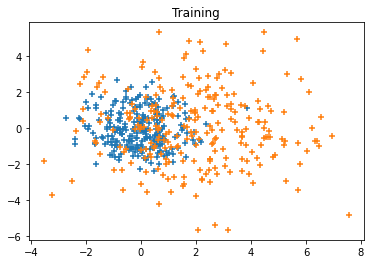

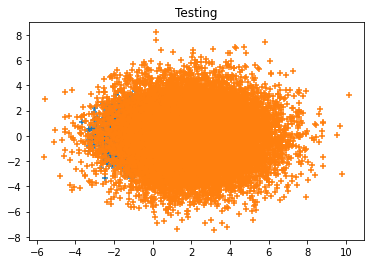

Probability of correct classification
[0.814125, 0.81075, 0.8096875, 0.808, 0.8040625]
Number of support vectors
[297, 280, 284, 292, 304]


In [50]:
acc = []
num_sv = []
for i in range(5):
    n_samples = 250
    x1, y1, x2, y2 = make_gaussian([0,0], [2,0], 1, 2, n_samples)
    if i == 0:
        plt.scatter(x1, y1, marker='+', linewidths=0.1)
        plt.scatter(x2, y2, marker='+', linewidths=0.1)
        plt.title('Training')
        plt.show()

    ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
    ds1 = np.vstack((x2,y2,np.zeros(n_samples))).T
    ds = np.vstack((ds0,ds1))
    np.random.shuffle(ds)

    X = ds[:,:2]
    y = ds[:,2]

    n_samples = 16000
    x1, y1, x2, y2 = make_gaussian([0,0], [2,0], 1, 2, n_samples)
    if i == 0:
        plt.scatter(x1, y1, marker='+', linewidths=0.1)
        plt.scatter(x2, y2, marker='+', linewidths=0.1)
        plt.title('Testing')
        plt.show()

    ds0 = np.vstack((x1,y1,np.ones(n_samples))).T
    ds1 = np.vstack((x2,y2,np.zeros(n_samples))).T
    ds = np.vstack((ds0,ds1))
    np.random.shuffle(ds)

    X_test = ds[:,:2]
    y_test = ds[:,2]
    
    model = SVC(C=1e-1, kernel='rbf')
    model.fit(X, y)

    y_pred = model.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))
    num_sv.append(model.support_vectors_.shape[0])
print('Probability of correct classification')
print(acc)
print('Number of support vectors')
print(num_sv)
